In [1]:
## Install Coqui TTS
! pip install -U pip
! pip install TTS

In [2]:
pwd

'/Users/mpellegrin008/Documents/VS_Code/CSCI104_Advanced_DL/TTS-dev/notebooks'

In [3]:
import os

# BaseDatasetConfig: defines name, formatter and path of the dataset.
from TTS.tts.configs.shared_configs import BaseDatasetConfig

output_path = "tts_train_dir"
if not os.path.exists(output_path):
    os.makedirs(output_path)
    

In [4]:
# Download and extract LJSpeech dataset.

!wget -O $output_path/LJSpeech-1.1.tar.bz2 https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2 
!tar -xf $output_path/LJSpeech-1.1.tar.bz2 -C $output_path

--2024-02-28 10:17:03--  https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2
Resolving data.keithito.com (data.keithito.com)... 24.199.73.137
Connecting to data.keithito.com (data.keithito.com)|24.199.73.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2748572632 (2.6G) [text/plain]
Saving to: ‘tts_train_dir/LJSpeech-1.1.tar.bz2’

tts_train_dir/LJSpe 100%[===================>]   2.56G  3.71MB/s    in 12m 32s 

2024-02-28 10:29:36 (3.48 MB/s) - ‘tts_train_dir/LJSpeech-1.1.tar.bz2’ saved [2748572632/2748572632]



In [5]:
dataset_config = BaseDatasetConfig(
    formatter="ljspeech", meta_file_train="metadata.csv", path=os.path.join(output_path, "LJSpeech-1.1/")
)

We will begin by initializing the model training configuration.

In [7]:
# GlowTTSConfig: all model related values for training, validating and testing.
from TTS.tts.configs.glow_tts_config import GlowTTSConfig
config = GlowTTSConfig(
    batch_size=32,
    eval_batch_size=16,
    num_loader_workers=4,
    num_eval_loader_workers=4,
    run_eval=True,
    test_delay_epochs=-1,
    epochs=5,
    text_cleaner="phoneme_cleaners",
    use_phonemes=True,
    phoneme_language="en-us",
    phoneme_cache_path=os.path.join(output_path, "phoneme_cache"),
    print_step=25,
    print_eval=False,
    mixed_precision=True,
    output_path=output_path,
    datasets=[dataset_config],
    save_step=1000,
)

Next we will initialize the audio processor which is used for feature extraction and audio I/O.

In [8]:
from TTS.utils.audio import AudioProcessor
ap = AudioProcessor.init_from_config(config)
# Modify sample rate if for a custom audio dataset:
# ap.sample_rate = 22050


 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:45
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024


Next we will initialize the tokenizer which is used to convert text to sequences of token IDs.  If characters are not defined in the config, default characters are passed to the config.

In [9]:
from TTS.tts.utils.text.tokenizer import TTSTokenizer
tokenizer, config = TTSTokenizer.init_from_config(config)

Next we will load data samples. Each sample is a list of ```[text, audio_file_path, speaker_name]```. You can define your custom sample loader returning the list of samples.

In [10]:
from TTS.tts.datasets import load_tts_samples
train_samples, eval_samples = load_tts_samples(
    dataset_config,
    eval_split=True,
    eval_split_max_size=config.eval_split_max_size,
    eval_split_size=config.eval_split_size,
)

 | > Found 13100 files in /Users/mpellegrin008/Documents/VS_Code/CSCI104_Advanced_DL/TTS-dev/notebooks/tts_train_dir/LJSpeech-1.1


Now we're ready to initialize the model.

Models take a config object and a speaker manager as input. Config defines the details of the model like the number of layers, the size of the embedding, etc. Speaker manager is used by multi-speaker models.

In [14]:
from TTS.tts.models.glow_tts import GlowTTS
model = GlowTTS(config, ap, tokenizer, speaker_manager=None)

Trainer provides a generic API to train all the 🐸TTS models with all its perks like mixed-precision training, distributed training, etc.

In [15]:
from trainer import Trainer, TrainerArgs
trainer = Trainer(
    TrainerArgs(), config, output_path, model=model, train_samples=train_samples, eval_samples=eval_samples
)

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
 > Training Environment:
 | > Backend: Torch
 | > Mixed precision: True
 | > Precision: fp16
 | > Num. of CPUs: 8
 | > Num. of Torch Threads: 8
 | > Torch seed: 54321
 | > Torch CUDNN: True
 | > Torch CUDNN deterministic: False
 | > Torch CUDNN benchmark: False
 | > Torch TF32 MatMul: False
 > Start Tensorboard: tensorboard --logdir=tts_train_dir/run-February-28-2024_10+35AM-0000000

 > Model has 28610257 parameters


### AND... 3,2,1... START TRAINING 🚀🚀🚀

In [ ]:
trainer.fit()


 > EPOCH: 0/5
 --> tts_train_dir/run-February-28-2024_10+35AM-0000000


[*] Pre-computing phonemes...


  0%|                                                                               | 5/12969 [00:00<18:27, 11.70it/s]

ɪnstɛd əv weɪtɪŋ ðɛɹ, ɔzwɔld əpɛɹəntli wɛnt æz fɑɹ əweɪ æz hi kʊd ænd bɔɹdɪd ðə fɚst oʊk klɪf bʌs wɪt͡ʃ keɪm əlɔŋ
 [!] Character '͡' not found in the vocabulary. Discarding it.


 16%|████████████                                                                | 2060/12969 [00:42<02:49, 64.54it/s]

ɪntu ðə “kɹeɪtɚ” dʌɡ aʊt ɪn ðə mɪdəl, pɔɹ ðə spʌnd͡ʒ, wɔɹm wɔtɚ, ðə məlæsɪz, ænd soʊdə dɪzɑlvd ɪn hɑt wɔtɚ.
 [!] Character '“' not found in the vocabulary. Discarding it.
ɪntu ðə “kɹeɪtɚ” dʌɡ aʊt ɪn ðə mɪdəl, pɔɹ ðə spʌnd͡ʒ, wɔɹm wɔtɚ, ðə məlæsɪz, ænd soʊdə dɪzɑlvd ɪn hɑt wɔtɚ.
 [!] Character '”' not found in the vocabulary. Discarding it.


100%|███████████████████████████████████████████████████████████████████████████| 12969/12969 [02:32<00:00, 84.80it/s]

 > TRAINING (2024-02-28 10:37:58) 




> DataLoader initialization
| > Tokenizer:
	| > add_blank: False
	| > use_eos_bos: False
	| > use_phonemes: True
	| > phonemizer:
		| > phoneme language: en-us
		| > phoneme backend: gruut
	| > 3 not found characters:
	| > ͡
	| > “
	| > ”
| > Number of instances : 12969
 | > Preprocessing samples
 | > Max text length: 188
 | > Min text length: 13
 | > Avg text length: 100.90014650319993
 | 
 | > Max audio length: 222643.0
 | > Min audio length: 24499.0
 | > Avg audio length: 144984.29755570978
 | > Num. instances discarded samples: 0
 | > Batch group size: 0.



   --> TIME: 2024-02-28 10:38:23 -- STEP: 0/406 -- GLOBAL_STEP: 0
     | > current_lr: 2.5e-07 
     | > step_time: 3.3064  (3.3064332008361816)
     | > loader_time: 21.141  (21.141019105911255)

 [!] `train_step()` retuned `None` outputs. Skipping training step.
 [!] `train_step()` retuned `None` outputs. Skipping training step.
 [!] `train_step()` retuned `None` outputs. Skipping training step.
 [!] `train_step()` retuned `None` outputs. Skipping training step.
 [!] `train_step()` retuned `None` outputs. Skipping training step.
 [!] `train_step()` retuned `None` outputs. Skipping training step.
 [!] `train_step()` retuned `None` outputs. Skipping training step.
 [!] `train_step()` retuned `None` outputs. Skipping training step.
 [!] `train_step()` retuned `None` outputs. Skipping training step.
 [!] `train_step()` retuned `None` outputs. Skipping training step.

   --> TIME: 2024-02-28 10:54:25 -- STEP: 25/406 -- GLOBAL_STEP: 25
     | > loss: 3.9270429611206055  (3.823307991027832

In [8]:
# !pip install tensorboard
!tensorboard --logdir tts_train_dir

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.16.2 at http://localhost:6006/ (Press CTRL+C to quit)
^C


## output from tensorboard on my local machine

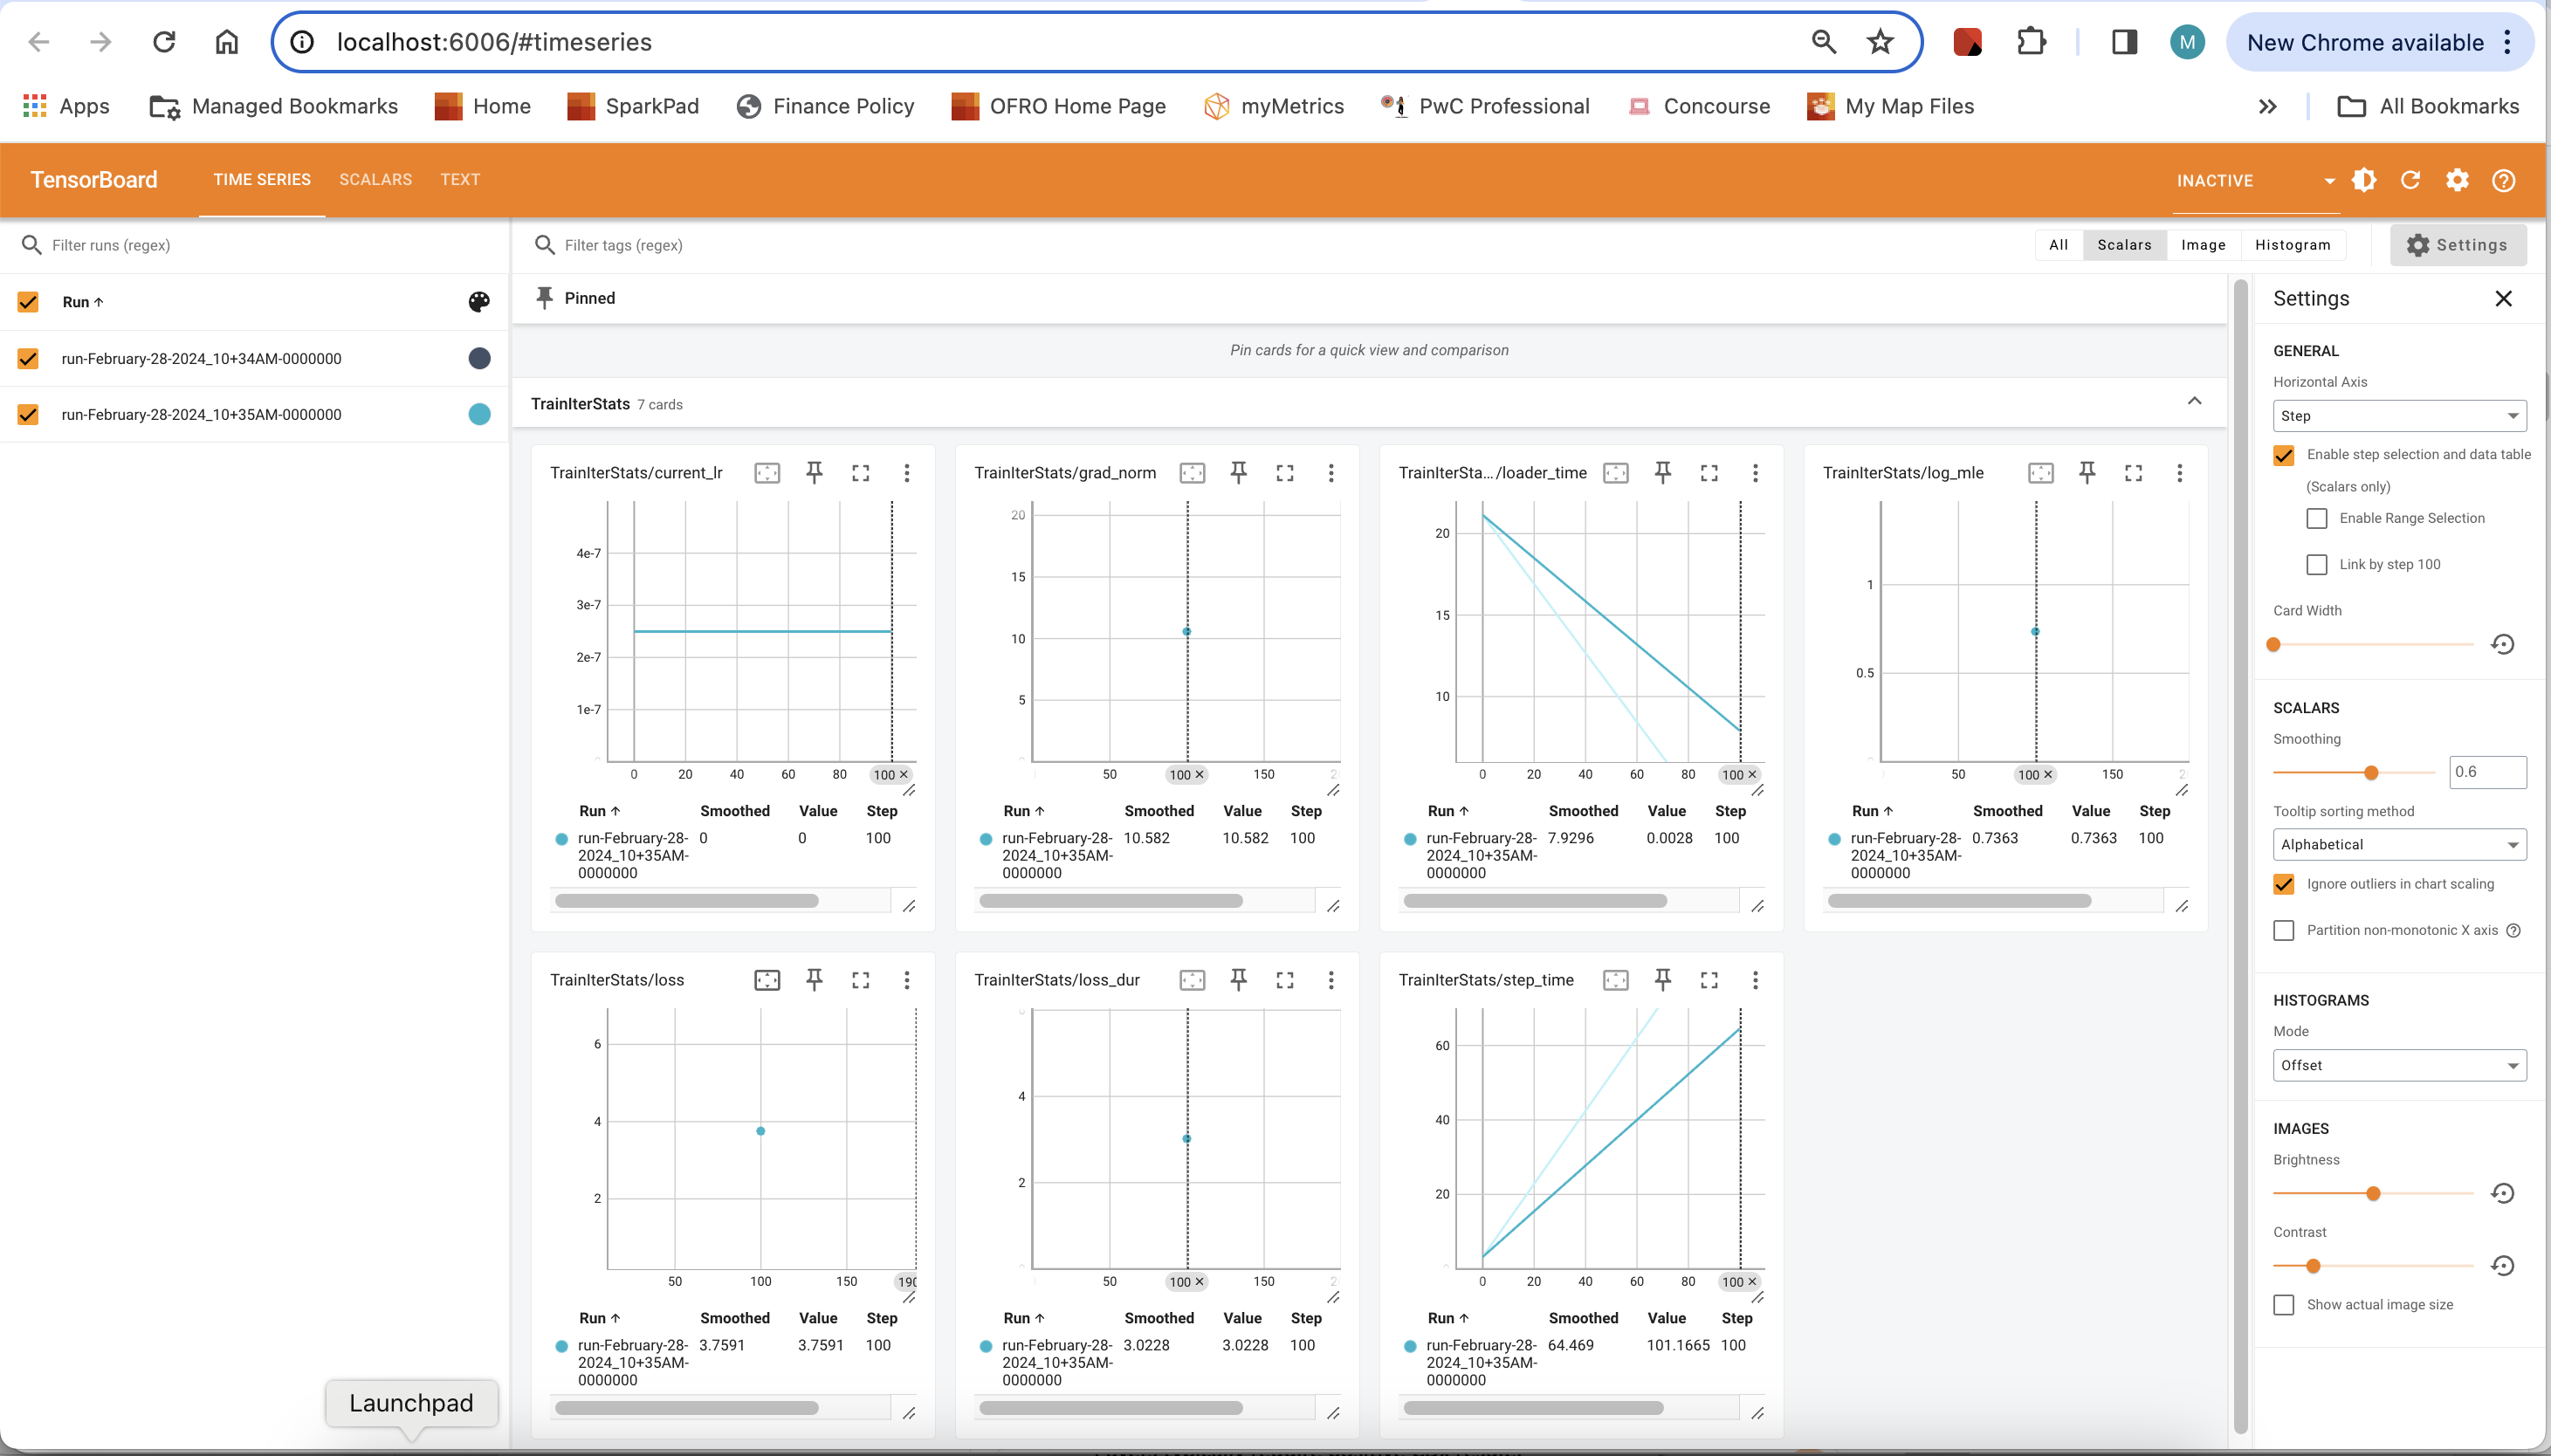

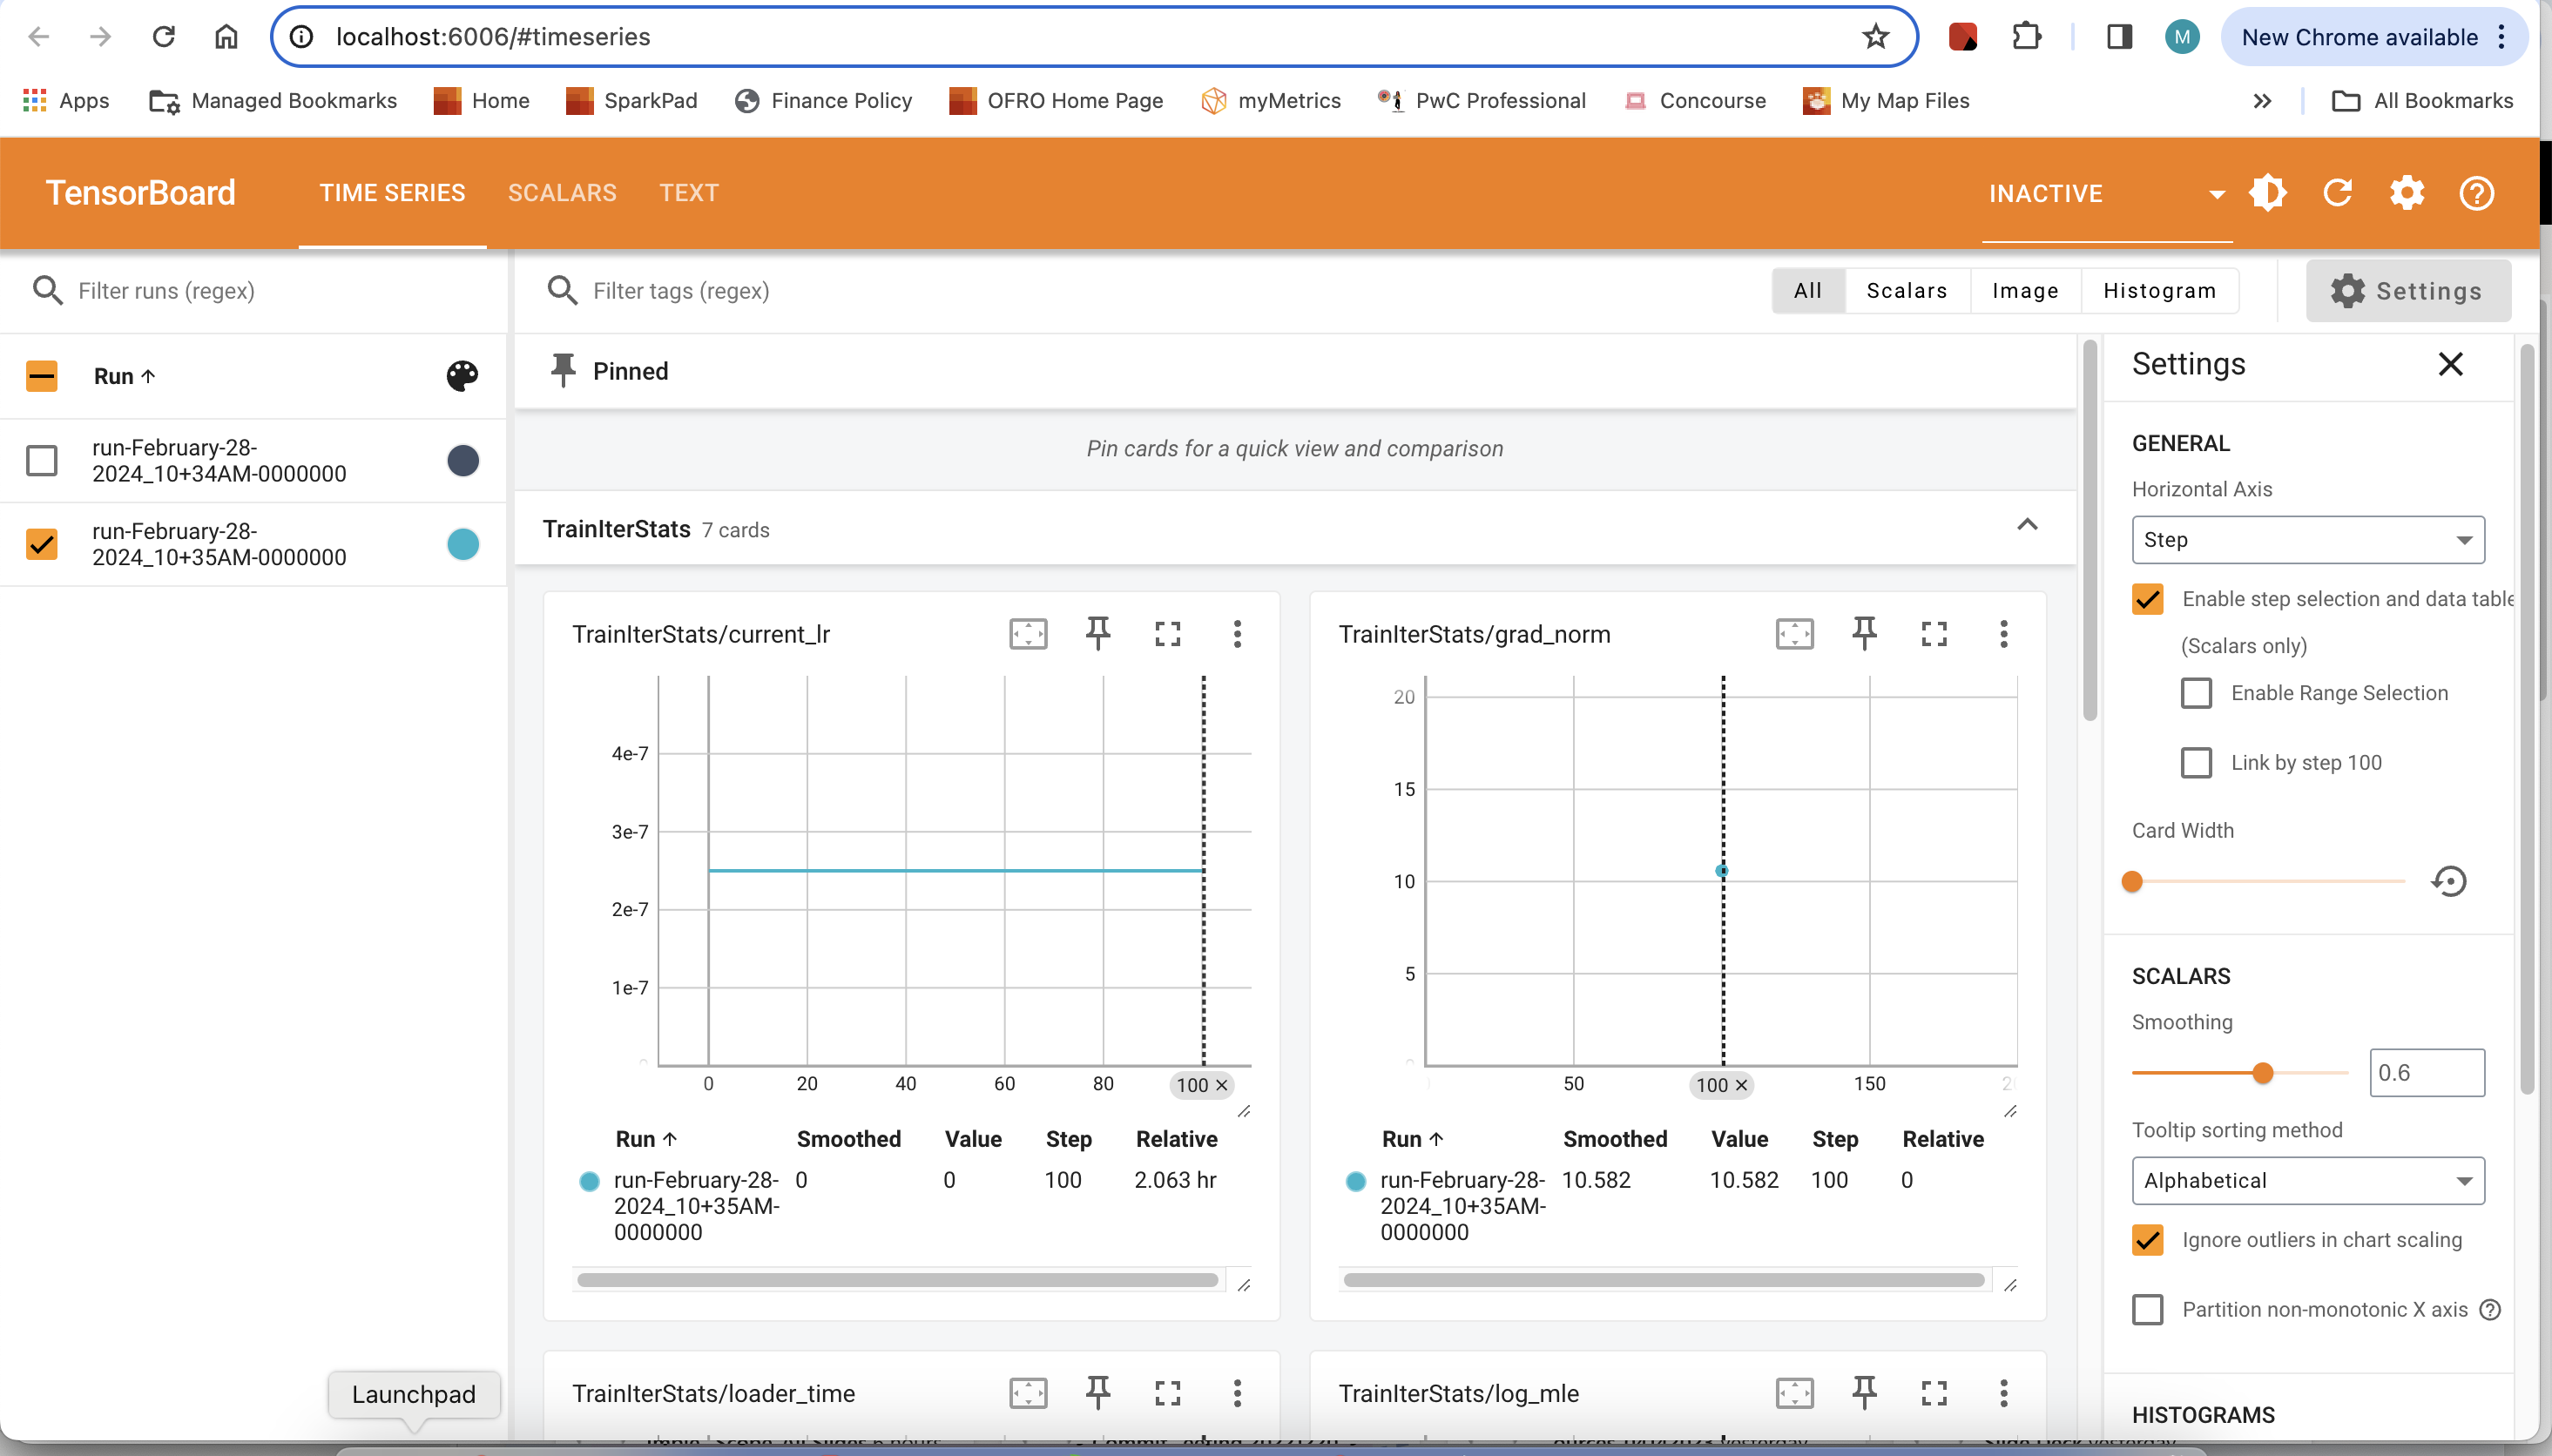

Let's get the latest saved checkpoint. 

In [6]:
import glob, os
output_path = "tts_train_dir"
ckpts = sorted([f for f in glob.glob(output_path+"/*/*.pth")])
configs = sorted([f for f in glob.glob(output_path+"/*/*.json")])

In [12]:
 !tts --text "Text for TTS" \
      --model_path /Users/mpellegrin008/Documents/VS_Code/CSCI104_Advanced_DL/TTS-dev/notebooks/tts_train_dir/run-February-28-2024_10+35AM-0000000/checkpoint_149.pth \
      --config_path /Users/mpellegrin008/Documents/VS_Code/CSCI104_Advanced_DL/TTS-dev/notebooks/tts_train_dir/run-February-28-2024_10+35AM-0000000/config.json \
      --out_path out.wav

 > Using model: glow_tts
 > Setting up Audio Processor...
 | > sample_rate:22050
 | > resample:False
 | > num_mels:80
 | > log_func:np.log10
 | > min_level_db:-100
 | > frame_shift_ms:None
 | > frame_length_ms:None
 | > ref_level_db:20
 | > fft_size:1024
 | > power:1.5
 | > preemphasis:0.0
 | > griffin_lim_iters:60
 | > signal_norm:True
 | > symmetric_norm:True
 | > mel_fmin:0
 | > mel_fmax:None
 | > pitch_fmin:1.0
 | > pitch_fmax:640.0
 | > spec_gain:20.0
 | > stft_pad_mode:reflect
 | > max_norm:4.0
 | > clip_norm:True
 | > do_trim_silence:True
 | > trim_db:45
 | > do_sound_norm:False
 | > do_amp_to_db_linear:True
 | > do_amp_to_db_mel:True
 | > do_rms_norm:False
 | > db_level:None
 | > stats_path:None
 | > base:10
 | > hop_length:256
 | > win_length:1024
 > Text: Text for TTS
 > Text splitted to sentences.
['Text for TTS']
 > Processing time: 0.5734078884124756
 > Real-time factor: 0.9135580881138068
 > Saving output to out.wav


## 📣 Listen to the synthesized wave 📣

In [13]:
import IPython
IPython.display.Audio("out.wav")